**RAG LAB 1 - Make your PDF bot**

PDF - Structured 

The langchain-community package contains third-party integrations. It is automatically installed by langchain, but can also be used separately.

In [1]:
import os
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Qdrant
from langchain_ollama import ChatOllama
from qdrant_client import QdrantClient
from langchain import PromptTemplate

from langchain.chains import RetrievalQA

--------------**I. INDEXING DATA**-----------------------------

**1. Load:** First we need to load our data. This is done with DocumentLoaders.

Unstructured currently supports loading of text files, powerpoints, html, pdfs, images, and more.

The UnstructuredPDFLoader depends on the unstructured library.




In [2]:
import os
import base64
from langchain_community.document_loaders import UnstructuredPDFLoader

In [3]:
pdf_path='.../Document-Buddy-App-main/temp.pdf'

In [ ]:
# For example, you can use the PyPDF loader, like PyPDFLoader:
#My sample PDF is of 3 pages.Hence, I need to load 3 documents

from langchain.document_loaders import PyPDFLoader

pdf_path = '.../Document-Buddy-App-main/temp.pdf'

if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"The file {pdf_path} does not exist.")

loader = PyPDFLoader(pdf_path)
docs = loader.load()

if not docs:
    raise ValueError("No documents were loaded from the PDF.")

print(f"Loaded {len(docs)} documents.")

Loaded 3 documents.


**2.Split:** 
Text splitters break large Documents into smaller chunks. 

This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won’t fit in a model’s finite context window.

you may want to split a long document into smaller chunks that can fit into your model's context window

**RecursiveCharacterTextSplitter**

Recursively splits text. This splitting is trying to keep related pieces of text next to each other. This is the recommended way to start splitting text.

Parameters Explained

chunk_size=1000:

This defines the maximum number of characters in each chunk.
Smaller chunks are easier to process and less likely to exceed model input limits.

chunk_overlap=250:

This defines the number of characters that will overlap between consecutive chunks.
Overlapping helps preserve context between chunks, which is useful for ensuring that important information isn't lost at chunk boundaries.

**How Overlapping Helps:**

If you overlap the last part of one page with the first part of the next page (by 250 characters), the listener hears the repeated context. This ensures they don’t miss important information that connects the two pages.

In [6]:
print(docs)

[Document(metadata={'source': '/Users/areefa/Desktop/llm_opensource/Document-Buddy-App-main/temp.pdf', 'page': 0}, page_content='A 76-Year-Old Woman  \nwith Stomach Cancer\nJOHN MULLEN, MD\nMassachusetts General Hospital\nPRESENTATION OF CASE\nA 76-year-old woman was seen in our \nmultidisciplinary gastrointestinal oncology clinic \nfor further management of an adenocarcinoma of \nthe body of the stomach. \nThe patient presented to her primary care \nphysician with a four-week history of intermittent \nchest pressure radiating to her back. Extensive \nevaluation for a cardiac source was unremarkable, \nincluding a normal stress test and abdominal \nultrasound. She then developed epigastric \nabdominal pain, and given that she carried \na history of prior H. pylori infection in 2003, \nthere was concern that she might have a peptic \nulcer. An upper endoscopy was obtained and \nshowed a large ulcerated tumor in the body of \nthe stomach (Figure 1). Pathological examination \nof biopsy s

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Define the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Max characters in each chunk
    chunk_overlap=250  # Overlapping characters for context preservation
)

# Apply the splitter to documents
splits = text_splitter.split_documents(docs)

# Check the result
if not splits:
    raise ValueError("No text chunks were created from the documents.")

print(f"Created {len(splits)} text chunks.")


Created 13 text chunks.


**3. Store:**

We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.


**Significance of Embedding Model**

A machine doesn’t understand English or any language like humans do—it sees everything as numbers. An embedding model helps by converting words, sentences, or documents into numerical representations, capturing their meaning and relationships. This allows a Retrieval-Augmented Generation (RAG) system to fetch the most relevant information, even when queries are phrased differently. Instead of just matching exact words, it understands context, synonyms, and intent, leading to more accurate and meaningful AI responses.

In [ ]:
pip install sentence-transformers  #Embeddings to create - we need this library

In [ ]:
#Clone a Embedding model from Hugging face:
#Execute following commands in terminal:
git lfs install
git clone https://huggingface.co/BAAI/bge-small-en

Reference link:https://huggingface.co/BAAI/bge-small-en

The **BAAI/bge-small-en** model is a lightweight embedding model for semantic search, text retrieval, and RAG. It efficiently converts text into dense vector representations, making it ideal for similarity searches. Pre-trained using contrastive learning, it ensures high-quality embeddings while being fast and resource-efficient. Suitable for use with FAISS, Milvus, and question-answering systems.

In [ ]:
pip install qdrant-client #install this in terminal

Qdrant is a high-performance, open-source vector database designed for efficient similarity search in machine learning and AI applications. It stores embeddings (vector representations of text, images, etc.) and enables fast and accurate retrieval based on vector similarity — making it perfect for tasks like semantic search, recommendation systems, and RAG (Retrieval-Augmented Generation). With features like filtering, payload support, and real-time updates, Qdrant integrates seamlessly into modern AI stacks and supports scalable, production-grade retrieval pipelines.

**Setup Qdrant**

https://hub.docker.com/r/qdrant/qdrant

Qdrant - vector similarity search engine with extended filtering support

Open Terminal & Install docker

**Verify Docker installation commands**

docker info

**To see if we have any images:**

docker images

**Now pull qdrant image:**

docker pull qdrant/qdrant

**Verify:**

docker images

This command should now list qdrant image

**Run image**

docker run -p 6333:6333 -v .:/qdrant/storage qdrant/qdrant

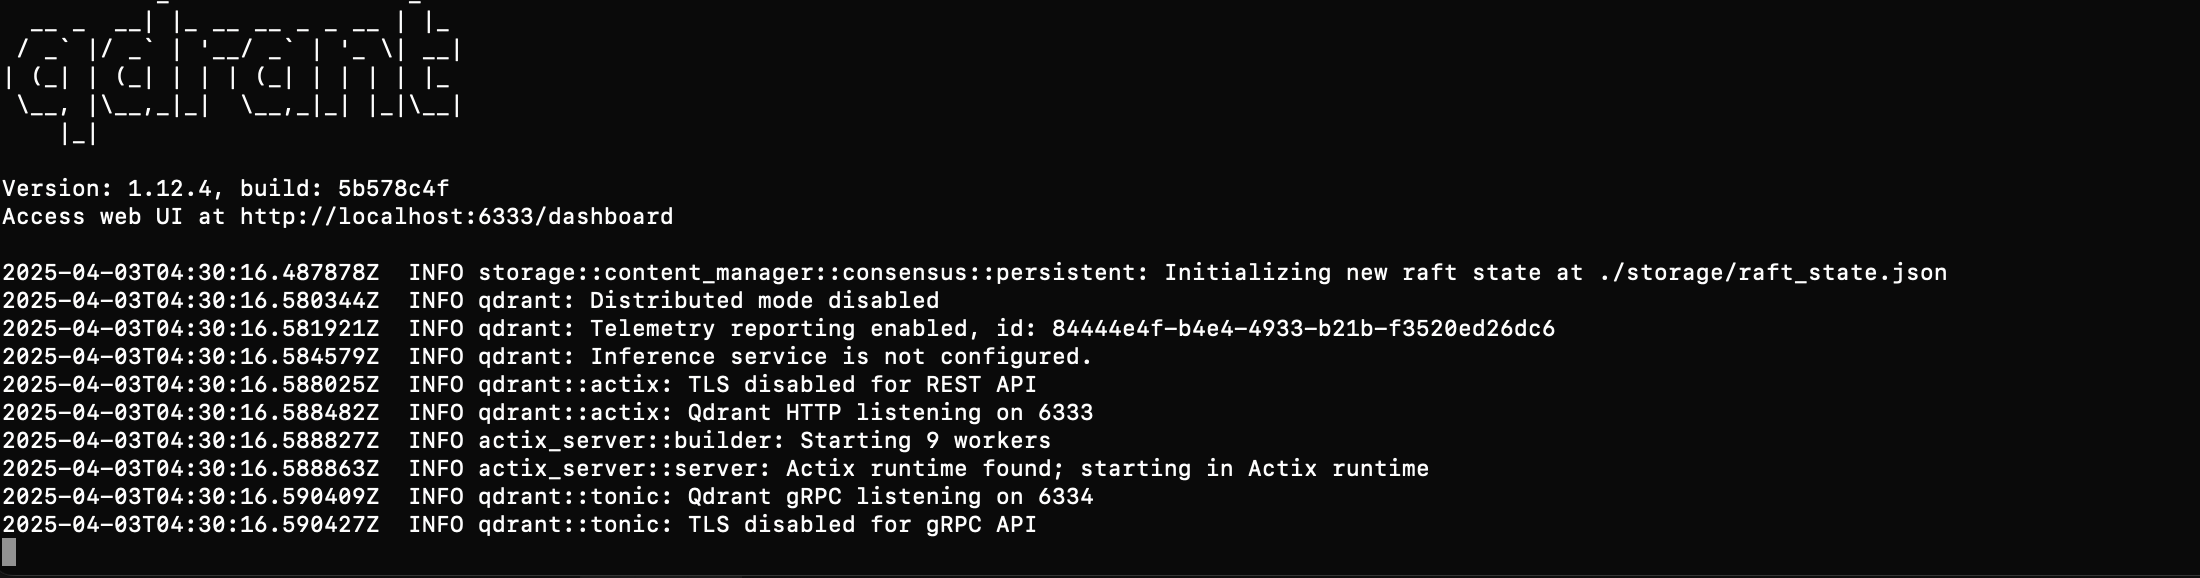

**Access Dashboard of Qdrant:** http://localhost:6333/dashboard

In [ ]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.vectorstores import Qdrant

# Parameters for embedding model and Qdrant
model_path= ".../bge-small-en"  # HuggingFace model name for embeddings
device = "cpu"                    # Device to run the model on ('cpu' or 'cuda')
encode_kwargs = {"normalize_embeddings": True}  # Additional encoding arguments
qdrant_url = "http://localhost:6333"            # Qdrant instance URL
collection_name = "stellar_db_1"                   # Qdrant collection name - give the name the way u want the collection to be created

# Initialize the embeddings model
#pip install sentence-transformers
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_path,
    model_kwargs={"device": device},
    encode_kwargs=encode_kwargs,
)

# Assume `splits` is the list of text chunks
try:
    # Create and store embeddings in Qdrant
    qdrant_db = Qdrant.from_documents(
        splits,
        embeddings,
        url=qdrant_url,
        prefer_grpc=False,  # Use HTTP for communication
        collection_name=collection_name,
    )
    print("✅ Vector DB Successfully Created and Stored in Qdrant!")
except Exception as e:
    raise ConnectionError(f"Failed to connect to Qdrant: {e}")


✅ Vector DB Successfully Created and Stored in Qdrant!


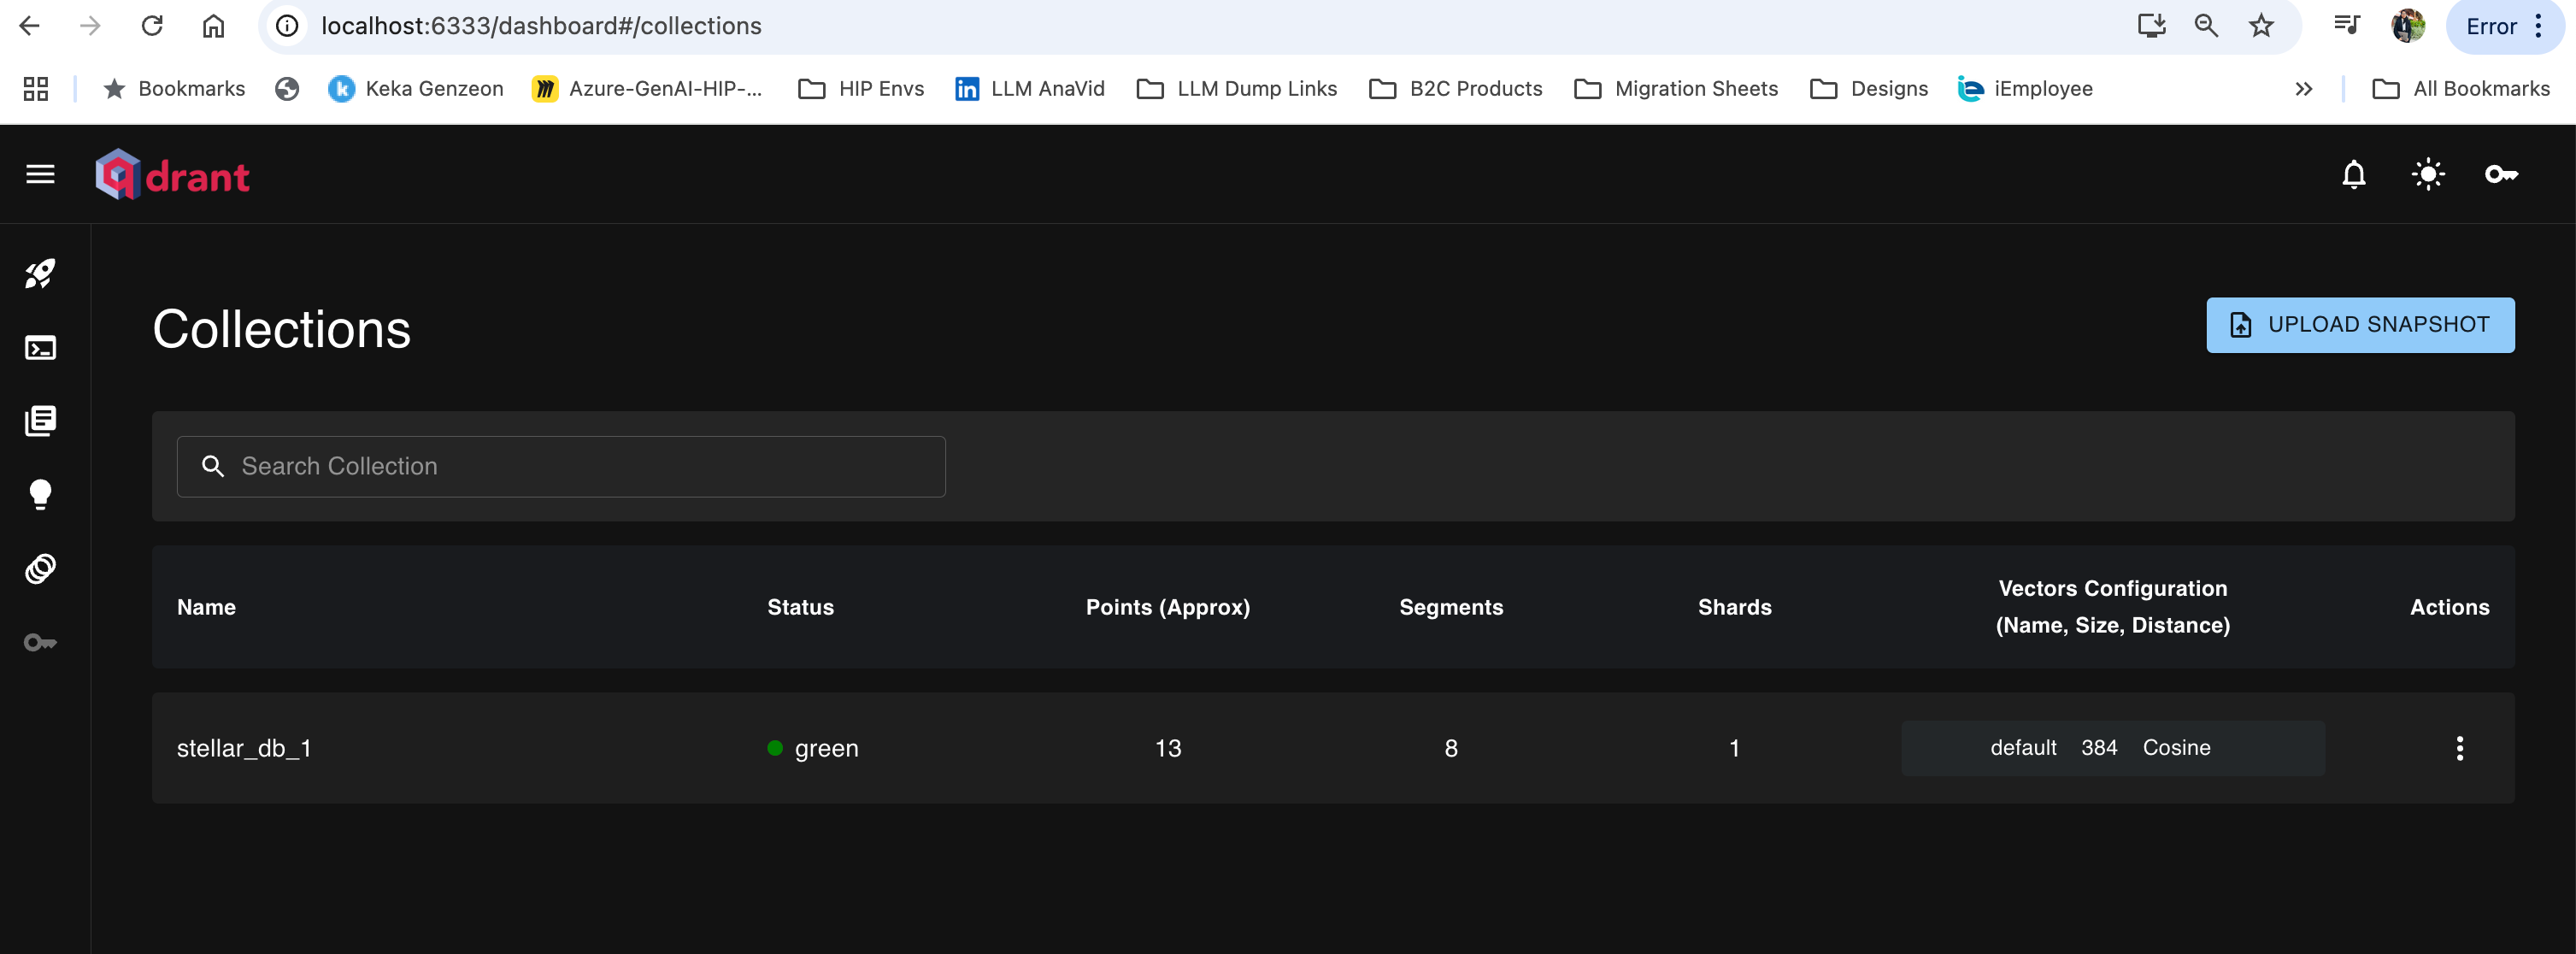

**COLLECTION CREATED**
collection currently contains approximately 13 vector embeddings. AS, THERE WERE 13 CHUNKS.

**Segments: 8**

A segment is a partition inside a Qdrant collection.

Segments are created to optimize search and update operations.

Having 8 segments means your data is distributed into 8 internal partitions, which helps with search and retrieval performance.

**Shards: 1**

Shards refer to the number of distributed parts the collection is divided into for **horizontal scaling.**

Since you have 1 shard, your collection is stored on a single Qdrant instance. If you need to handle larger datasets or higher throughput, you can increase the number of shards.

--------------**II. RETRIEVAL AND GENERATION**-----------------------------

**Step 1. Retrieve:**

Given a user input, relevant splits are retrieved from storage using a Retriever.

Retriever:

Pulls the most relevant documents (chunks of text) from the vector store based on similarity to the query.
We retrieve k=1 (top 1 document) for simplicity.


**How Query Embedding Works in LangChain:**
Retriever Initialization:

When you create a retriever using qdrant_db.as_retriever, the retriever is automatically linked to the embedding model (HuggingFaceBgeEmbeddings in your case) that was used to store the documents in the vector store.
Query Embedding Generation:

When you call retriever.get_relevant_documents(query):
The query is passed to the embedding model.
The embedding model converts the query into a numerical vector (same process used for document embeddings).
This query vector is then compared with the document vectors stored in the Qdrant vector store to find the most relevant documents.
Consistency:

Since the same embedding model (HuggingFaceBgeEmbeddings) is used for both the documents and the query, the embeddings are guaranteed to exist in the same vector space. This ensures accurate similarity matching.

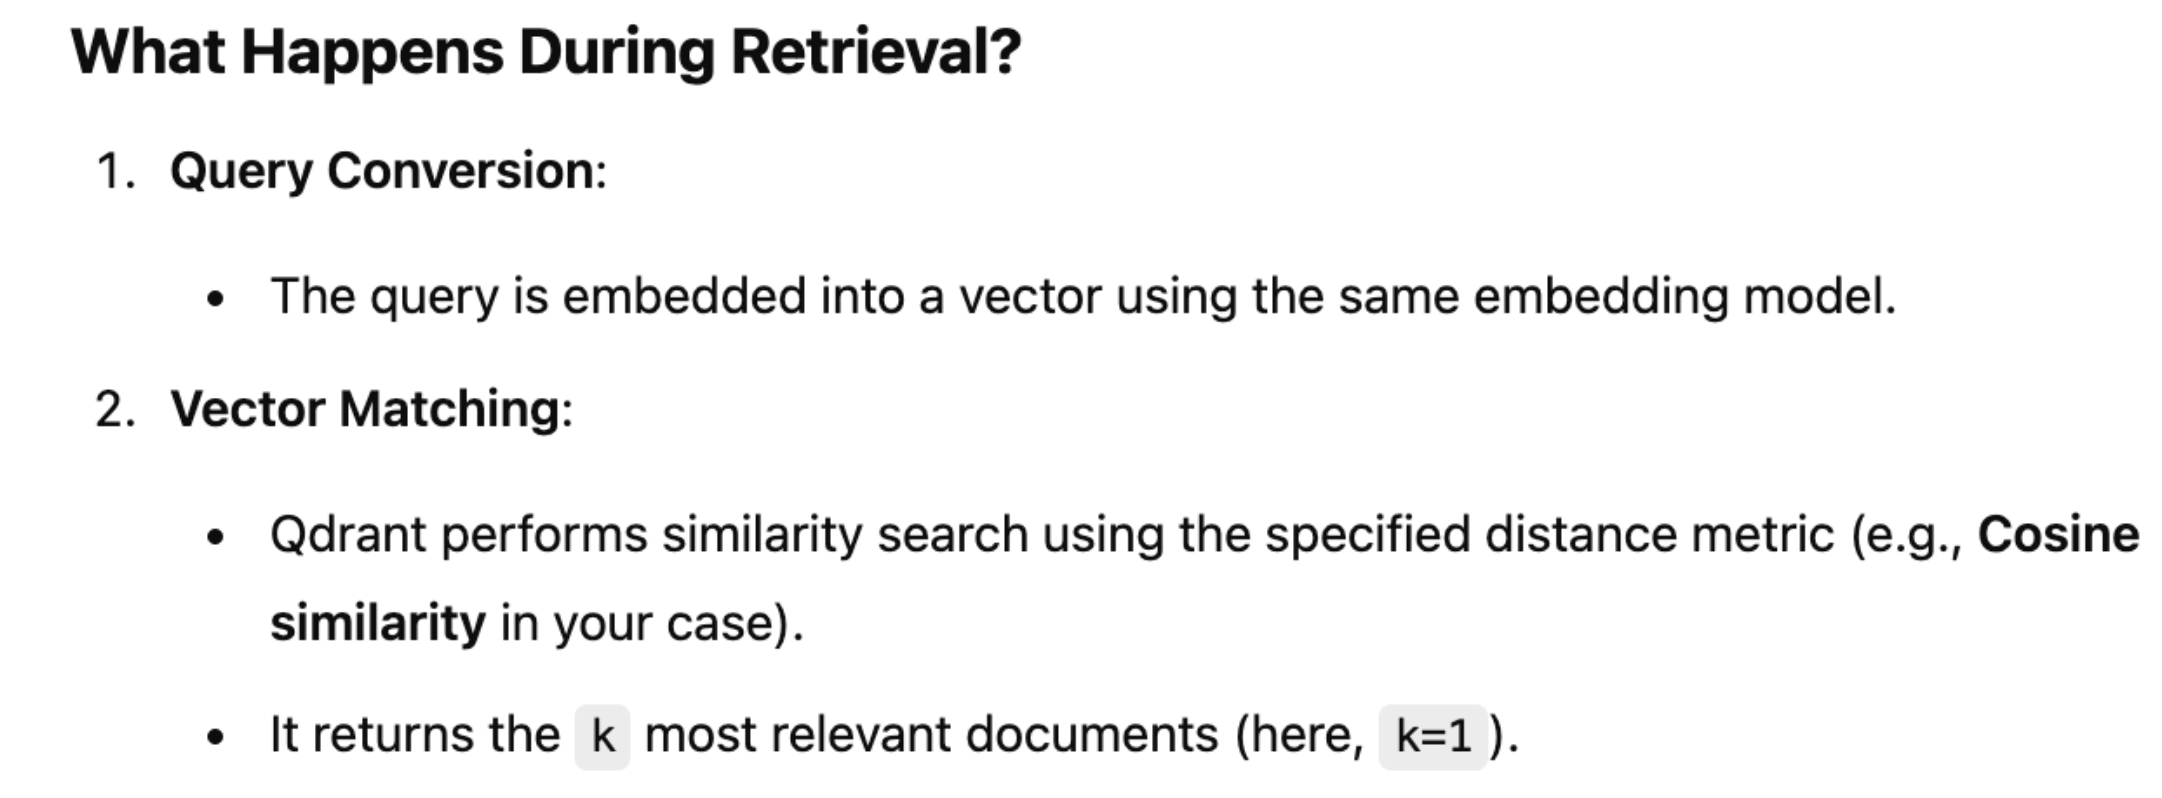



**Retriever Creation for reference**

In [ ]:
from langchain import PromptTemplate
from langchain.chains import RetrievalQA

# Initialize the retriever
retriever = qdrant_db.as_retriever(search_kwargs={"k": 1})  # Retrieve top 1 document
#fetching the top 1 most relevant document. If you want top 3 relevant docs change k to 3
print("✅ Retriever initialized successfully!")

# Test the retriever by querying it with a sample query
query = "List down all past medical history available"  # Example user query
retrieved_docs = retriever.get_relevant_documents(query)

# Display retrieved documents
print(f"Retrieved Documents:\n{retrieved_docs}")


✅ Retriever initialized successfully!
Retrieved Documents:
[Document(metadata={'source': '/Users/areefa/Desktop/llm_opensource/Document-Buddy-App-main/temp.pdf', 'page': 0, '_id': 'e824d3d5-8eaa-4b3f-a2b0-7306e67bd743', '_collection_name': 'stellar_db_1'}, page_content='Her past medical history was notable for type \nII diabetes mellitus, hypertension, elevated \nlipids, gastroesophageal reflux disease (GERD), \ndiverticulosis, endometriosis, kidney stones, \nanxiety and osteopenia. Her medications included \natorvastatin, Inderal, lisinopril, metformin, \nomeprazole and Paxil. She had allergies to dyazide, \nmorphine, intravenous contrast dye, aspirin and \ntriamcinolone cream. She was a retired research \nassistant and was married with two children. She \nnever smoked and did not drink alcohol. There \nwas no family history of stomach cancer, but her \nolder brother died of colon cancer metastatic to \nthe liver and lung at the age of 90.\nOn examination, the weight was 182 pounds, t

**Step 2: Augmentation (Prompt and RetrievalQA Chain)**

In this step, we define the prompt template and create a RetrievalQA chain that integrates the retriever with the LLM.

In [20]:
from langchain.chains import RetrievalQA
from langchain_ollama import ChatOllama

# Initialize Local LLM (e.g., Llama model)
llm_model = "llama3.2:3b"  # Specify your LLM model
llm_temperature = 0.7       # Adjust temperature for creative/precise responses

llm = ChatOllama(
    model=llm_model,
    temperature=llm_temperature,
)

# Define the prompt template
prompt_template = """Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Question: {question}

Only return the helpful answer. Answer must be detailed and well explained.
Helpful answer:
"""

prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)

# Define chain type kwargs
chain_type_kwargs = {"prompt": prompt}

# Initialize the RetrievalQA chain - **Chain Initialization**
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,                           # The LLM
    chain_type="stuff",                # Default chain type for processing retrieved text. If your retrieved documents are longer or you need summarization, consider map_reduce or refine.
    retriever=retriever,               # The retriever
    return_source_documents=True,     # Only return the result, not the source documents -> Then make it False
    chain_type_kwargs=chain_type_kwargs,
    verbose=False                      # Set True to debug or log outputs
)

print("✅ Augmentation chain initialized successfully!")


✅ Augmentation chain initialized successfully!


**Step 3: Query and Response**

Now that the retriever and augmentation chain are set up, you can test the system with a query.

In [21]:
# Example user query
query = "List down all past medical history available"

# Run the query through the QA chain
try:
    response = qa_chain.run(query) #response = ['result', 'source_documents']
    print("Response:", response[0])
    print("Source/References:",response[1])
except Exception as e:
    print(f"⚠️ An error occurred while processing the query: {e}")


⚠️ An error occurred while processing the query: `run` not supported when there is not exactly one output key. Got ['result', 'source_documents'].


**The error occurs because the qa_chain.run() method is designed to return a single output key, but your chain is configured to output two keys: 'result' (the chatbot's response) and 'source_documents' (the retrieved documents). To handle this, you need to explicitly call qa_chain() as a dictionary and extract the desired outputs.**

In [22]:
# Example user query
query = "List down all past medical history available"

# Run the query through the QA chain
try:
    #when you initialize RetreivalQA chain : return_source_documents=True,then you need to pass the query as a dictionary
    response = qa_chain({"query": query})  # Pass the query as a dictionary
    print("Response:", response['result'])  # Get the chatbot's response
    print("Source/References:", response['source_documents'])  # Get the source documents
except Exception as e:
    print(f"⚠️ An error occurred while processing the query: {e}")


Response: Based on the provided information, her notable past medical histories include:

1. Type II diabetes mellitus
2. Hypertension
3. Elevated lipids
4. Gastroesophageal reflux disease (GERD)
5. Diverticulosis
6. Endometriosis
7. Kidney stones
8. Anxiety
Source/References: [Document(metadata={'source': '/Users/areefa/Desktop/llm_opensource/Document-Buddy-App-main/temp.pdf', 'page': 0, '_id': 'e824d3d5-8eaa-4b3f-a2b0-7306e67bd743', '_collection_name': 'stellar_db_1'}, page_content='Her past medical history was notable for type \nII diabetes mellitus, hypertension, elevated \nlipids, gastroesophageal reflux disease (GERD), \ndiverticulosis, endometriosis, kidney stones, \nanxiety and osteopenia. Her medications included \natorvastatin, Inderal, lisinopril, metformin, \nomeprazole and Paxil. She had allergies to dyazide, \nmorphine, intravenous contrast dye, aspirin and \ntriamcinolone cream. She was a retired research \nassistant and was married with two children. She \nnever smoked 

🎩🪄 **Tada! Now, experiment with various queries!** 🔍💬



║ **🎥  BEHIND THE SCENES – BTS OF THIS LAB 🎬** ║



Peek into the engine room of Retrieval-Augmented Generation (RAG) with LangChain + Qdrant + Ollama.


![BTS Logo](https://img.shields.io/badge/BTS_LAB-UNDER_THE_HOOD-blueviolet?style=for-the-badge&logo=databricks&logoColor=white)


 Let's walk through **exactly how your query**:

```python
query = "List down all past medical history available"
response = qa_chain.run(query)
```

gets processed by your **RetrievalQA pipeline**, step by step — including **retriever logic**, **prompt template mapping**, and **LLM generation**.

---

## Step-by-Step Explanation

### 🔹 Step 1: `qa_chain.run(query)`
This is the starting point. You provide the user query:

```python
"List down all past medical history available"
```

This query is passed to the **RetrievalQA chain**, which is composed of:

1. A **retriever** (from Qdrant)
2. A **PromptTemplate**
3. A **Local LLM** (Ollama + Llama3.2:3b)

---

### 🔹 Step 2: Retrieval of Relevant Documents

The retriever kicks in:

```python
retriever = qdrant_db.as_retriever(search_kwargs={"k": 1})
```

LangChain calls:
```python
retriever.get_relevant_documents("List down all past medical history available")
```

✅ What it does:
- Embeds your query using the same embedding model used for indexing Qdrant.
- Searches the vector space in Qdrant using **cosine similarity** or similar distance metric.
- Retrieves the top **1 most relevant document** from your Qdrant collection.

🗂️ Example retrieved content (simulated):

```text
"The patient has a history of diabetes mellitus, hypertension, and prior cardiac surgery in 2015."
```

This result is stored as a variable — let's call it `retrieved_context`.

---

### 🔹 Step 3: Filling the Prompt Template

Here’s your defined prompt:

```python
prompt_template = """Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Question: {question}

Only return the helpful answer. Answer must be detailed and well explained.
Helpful answer:
"""
```

LangChain fills in the placeholders:
```python
PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)
```

🧩 So the final prompt sent to the LLM becomes:

```text
Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: The patient has a history of diabetes mellitus, hypertension, and prior cardiac surgery in 2015.
Question: List down all past medical history available

Only return the helpful answer. Answer must be detailed and well explained.
Helpful answer:
```

✅ This **augmented input** is what the LLM (Llama3.2:3b via Ollama) receives and uses to generate the final output.

---

### 🔹 Step 4: LLM Generates the Answer

The LLM processes the prompt and returns something like:

```text
The patient has the following past medical history:
1. Diabetes Mellitus
2. Hypertension
3. Cardiac surgery performed in 2015, indicating a previous cardiovascular issue.

These conditions suggest a chronic health profile that may influence ongoing care.
```

LangChain returns this as `response`.

---

### 📘 Final Output

```python
print(f"📘 Final Answer:\n{response}")
```

Prints:

```
📘 Final Answer:
The patient has the following past medical history:
1. Diabetes Mellitus
2. Hypertension
3. Cardiac surgery performed in 2015, indicating a previous cardiovascular issue.
```

---

## 🧩 Mapping Summary

| Component         | Role                                                                 |
|------------------|----------------------------------------------------------------------|
| `query`          | User's input/question                                                |
| `retriever`      | Finds relevant docs in Qdrant using embeddings                       |
| `retrieved_docs` | Top-K (k=1) docs based on similarity                                 |
| `prompt_template`| Fills `{context}` with retrieved doc, `{question}` with user query   |
| `LLM` (ChatOllama)| Answers based on prompt (context + question)                        |
| `qa_chain.run()` | Ties all steps together and returns the final answer                 |

---

## 🛠️ Optional Tip: Debug the Final Prompt

If you want to *see* the final prompt passed to the LLM, you can manually format it:

```python
print(prompt.format(context=retrieved_docs[0].page_content, question=query))
```

Let me know if you want to:
- visualize this flow,
- switch to streaming output,
- or convert it into a chatbot or API!